In [1]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import os
#import glob
#import scipy.misc
#import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
#import warnings; warnings.simplefilter('ignore')
import h5py
from skimage import io
from training_func import *
from PIL import Image


In [3]:
#HR = 64
#LR = 8

In [6]:
#Import res 64
y_64_val = np.load("../fil/val_Nu_64Res_3L.npy")
y_64_tr = np.load("../fil/train_Nu_64Res_3L.npy")

In [7]:
y_32_val = np.load("../fil/val_Nu_32Res_3L.npy")
y_32_tr = np.load("../fil/train_Nu_32Res_3L.npy")

In [8]:
y_16_val = np.load("../fil/val_Nu_16Res_3L.npy")
y_16_tr = np.load("../fil/train_Nu_16Res_3L.npy")

In [10]:
y_8_val = np.load("../fil/val_Nu_8Res_3L.npy")
y_8_tr = np.load("../fil/train_Nu_8Res_3L.npy")

In [12]:
##SupRes interpolation
x_tr_8 = np.asarray([MakeCron(x[:,:,0],8) for x in y_8_tr])
x_val_8 = np.asarray([MakeCron(x1[:,:,0],8) for x1 in y_8_val])

x_tr_8 = np.expand_dims(x_tr_8,axis=3)
x_val_8 = np.expand_dims(x_val_8,axis=3)


In [13]:
#Define Fractions
z_64_tr = y_64_tr/ x_tr_8
z_64_val= y_64_val/x_val_8

z_64_tr[np.where(np.isnan(z_64_tr))]=0.
z_64_val[np.where(np.isnan(z_64_val))]=0.

/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


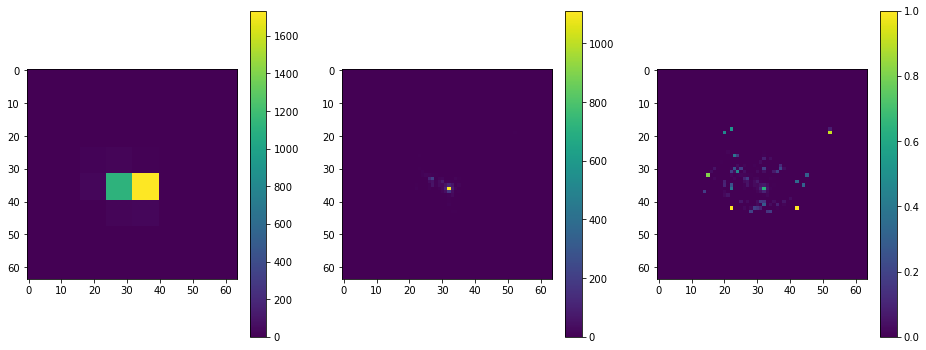

In [14]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(x_val_8[0,:,:,0])
plt.colorbar()

plt.subplot(132)
plt.imshow(y_64_val[0,:,:,0])
plt.colorbar()

plt.subplot(133)
plt.imshow(z_64_val[0,:,:,0])
plt.colorbar()

plt.show()

In [16]:
from keras.backend import sigmoid
import tensorflow as tf
from keras.layers import Lambda, UpSampling2D, ZeroPadding2D
from keras import backend as K, Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten, Add
from keras.layers import Input, Concatenate
from keras.models import Model

#Input Preprocessed SupRes
image = Input((64, 64, 1), name = "Input")

#### === UPCONV === #####

#x = Conv2D(16, (1, 1), activation="tanh", padding="same",name="Up1")(image)
#x = Conv2D(32, (1, 1), activation="relu", padding="same",name="Up2")(x)
#x = Conv2D(64, (1, 1), activation="relu", padding="same",name="Up3")(x)

#SR =Lambda(lambda x:tf.nn.depth_to_space(x,block_size=8), name = "PS_S")(x)

### === SRCNN === ###

x = Conv2D(64, (9, 9), activation='relu', padding='same', name = "PERep")(image)
x = Conv2D(32, (1, 1), activation='relu', padding='same', name = "NLM")(x)
srcnn = Conv2D(1, (5, 5), activation='relu', padding='same', name = "Rec")(x)



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
PERep (Conv2D)               (None, 64, 64, 64)        5248      
_________________________________________________________________
NLM (Conv2D)                 (None, 64, 64, 32)        2080      
_________________________________________________________________
Rec (Conv2D)                 (None, 64, 64, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
None


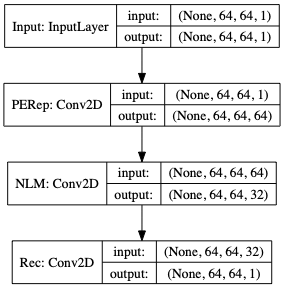

In [17]:
model = Model(inputs=image, outputs=srcnn)
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,rankdir="TB", dpi = 70)


In [27]:

A = tf.convert_to_tensor(np.arange(64*64))
A= tf.reshape(A,(8, 8, 64))
print(A[:,:,0])

tf.Tensor(
[[   0   64  128  192  256  320  384  448]
 [ 512  576  640  704  768  832  896  960]
 [1024 1088 1152 1216 1280 1344 1408 1472]
 [1536 1600 1664 1728 1792 1856 1920 1984]
 [2048 2112 2176 2240 2304 2368 2432 2496]
 [2560 2624 2688 2752 2816 2880 2944 3008]
 [3072 3136 3200 3264 3328 3392 3456 3520]
 [3584 3648 3712 3776 3840 3904 3968 4032]], shape=(8, 8), dtype=int64)


In [2]:
import keras.backend as kb
import tensorflow as tf

#def split(array, nrows, ncols):
#    a, r, h, n = array.shape
#    array = tf.reshape(array,(h//nrows, nrows, -1, ncols))
#    array= tf.transpose(array, perm=[0,2,1,3])
#    array=tf.reshape(array, ( -1,nrows, ncols))
#    array= tf.transpose(array, perm=[1,2,0])
#    a,b,c=array.shape
#    array=tf.reshape(array, (-1,a,b,c,1) )
#    return array
#
#t = np.arange(0,64*64,1).reshape(-1,64,64,1)
#t = tf.convert_to_tensor(t)
#print(t.shape)
#t = split(t, 8, 8)
#print(t.shape)
#print(t[0,:,:,0,0])

def myloss(image):
    
    def pere( tar_,pred_):
        
        
        print(image.shape)
        
        
        tar = tf.where(tar_<=0., 0., tar_)
        pred = tf.where(tar_<=0., 0., pred_)

        tot = kb.sum(pred)

        ## In this way kb.sum(pred) == 1
        pred/=tot
        
        ## In this way kb.sum(pred) == Total energy of the imput image
        pred=tf.math.multiply(pred,image)
        
        
        ##I Want to do this but for each non superres-cell
        #cp = 1
            
        ### === Cell === ###
        cell = kb.mean((pred-tar) * (pred-tar))
        #cell /= kb.sum(tar)

        
        return cp * cell 

    return pere


Using TensorFlow backend.
/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lox/opt

In [20]:
NEP_max = 10000
#opt = Adam(learning_rate=0.0001)
model.compile(loss=myloss, optimizer="adam")

VL = np.zeros(NEP_max)
TL = np.zeros(NEP_max)

k = 0
TL_min = float("inf")
VL_min = float("inf")


for epoch in range(NEP_max):
    print("Epoch: ===== ", epoch)
    history = model.fit(x=y_8_tr,y=y_64_tr,
                        batch_size=50,
                        epochs=1,
                        validation_data=[y_8_val, y_64_val])

    VL_ =history.history["val_loss"][0]
    TL_ =history.history["loss"][0]
    VL[epoch] = VL_
    TL[epoch] = TL_
    
    if TL_>= TL_min:
        k+=1
    if TL_< TL_min:
        k = 0
        TL_min = TL_
        
    if VL_<TL_*(1+0.05)/(1-0.05) and k <4:
        model.save("model.hdf5")
        continue
    
    
    
    
    
    break
    

Epoch: =====  0
Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 193s 12ms/step - loss: 7227.0409 - val_loss: 512.5059
Epoch: =====  1
Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 211s 13ms/step - loss: 453.2116 - val_loss: 404.9179
Epoch: =====  2
Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 199s 12ms/step - loss: 453.3000 - val_loss: 306.0040
Epoch: =====  3
Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 209s 13ms/step - loss: 485.3739 - val_loss: 322.5846
Epoch: =====  4
Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 228s 14ms/step - loss: 545.5408 - val_loss: 304.7279
Epoch: =====  5
Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 19

In [15]:
#import tensorflow as tf
#from keras.models import load_model
#model = load_model("model.hdf5")

/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/lox/opt/anaconda3/envs/piton3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


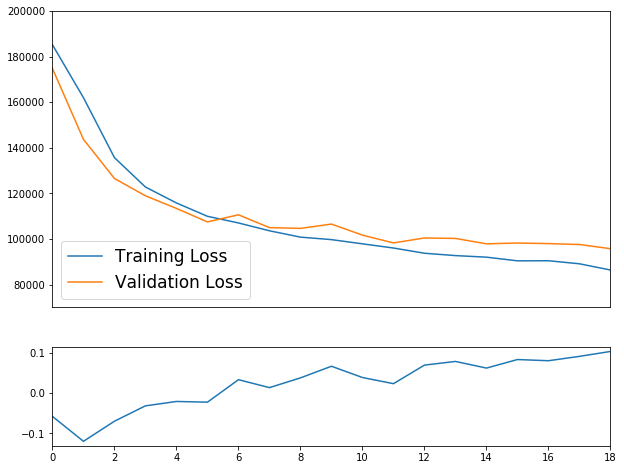

In [16]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,8))

#a0.title("BICUBIC Loss")
a0.plot(TL,label="Training Loss")
a0.plot(VL, label="Validation Loss")
a0.axis(xmin=0,xmax=int(epoch),ymin=70000,ymax=200000)
a0.xaxis.set_visible(False)
a0.legend(loc = "lower left", fontsize = 17)

a1.plot(2*(VL-TL)/(TL+VL))
a1.axis(xmin=0,xmax=int(epoch))
f.show()



In [17]:
from training_func import *
from math import *
from sklearn.cluster import KMeans
from matplotlib.colors import LogNorm

In [18]:

#y_ = np.load("fil/val_Nu_SupRes_3L.npy")
#y_ = np.expand_dims(y_[: ,1,:HR,:HR], axis=3)
#
#x_small_ = np.load("fil/val_Nu_RealRes_3L.npy")
#x_small_ = np.expand_dims(x_small_[: ,1,:LR,:LR], axis=3)

f = h5py.File("fil/truth_info_3L.h5","r")
orX = f["Ev_X_or"]
orY = f["Ev_Y_or"]


In [19]:
pred = model.predict(y_8_val)


In [20]:
pred.shape

(4000, 64, 64, 1)

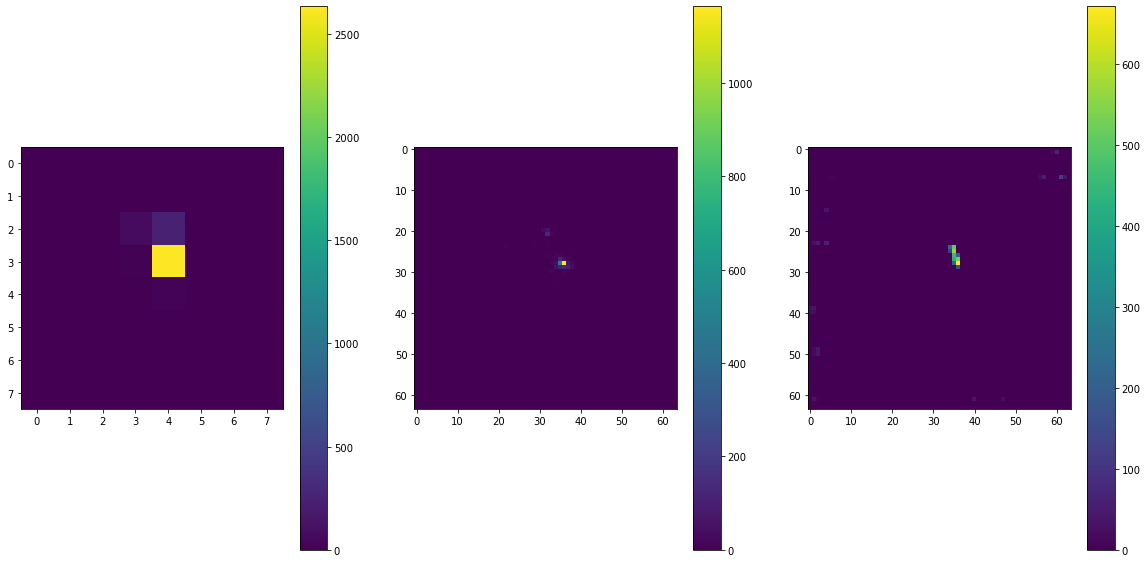

In [21]:
ev = 1
plt.figure(figsize=(20,10))

loc = np.where(y_8_val[ev,:,:,0]>0.)


plt.subplot(131)
plt.imshow(y_8_val[ev,:,:,0])
plt.colorbar()

plt.subplot(132)
plt.imshow(y_64_val[ev,:,:,0])
plt.colorbar()

plt.subplot(133)
plt.imshow(pred[ev,:,:,0])
plt.colorbar()



plt.show()

In [22]:
print()
NN = y_8_val.shape[0]
MER = np.zeros(NN)
#print(x_small_.shape)

for ev in range(NN):
    
    if ev%200==0: print("Ev: ==== ",ev)
    
    loc = np.where(y_8_val[ev,:,:,0]>0.)
    
    
    if len(loc[0])<1: 
        MER[ev]=-1
        print(ev)
        continue
        
    suploc = Make_Sup_Loc(loc,8)
    
    EML=np.sum(pred[ev,:,:,0][suploc])
    ETR=np.sum(y_64_val[ev,:,:,0][suploc])
    

    MER[ev]=(EML-ETR)/ETR

    



Ev: ====  0
Ev: ====  200
Ev: ====  400
Ev: ====  600
Ev: ====  800
Ev: ====  1000
Ev: ====  1200
Ev: ====  1400
Ev: ====  1600
Ev: ====  1800
Ev: ====  2000
Ev: ====  2200
Ev: ====  2400
Ev: ====  2600
Ev: ====  2800
Ev: ====  3000
Ev: ====  3200
Ev: ====  3400
Ev: ====  3600
Ev: ====  3800
3949


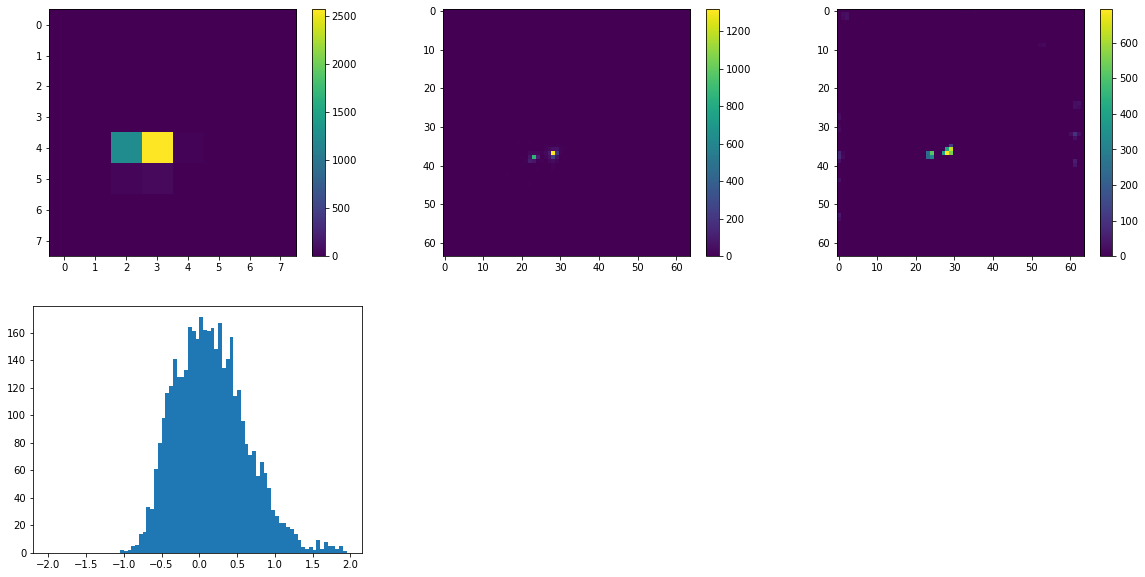

In [23]:
ev = 12
plt.figure(figsize=(20,10))

loc = np.where(y_8_val[ev,:,:,0]>0.)


plt.subplot(231)
plt.imshow(y_8_val[ev,:,:,0])
plt.colorbar()

plt.subplot(232)
plt.imshow(y_64_val[ev,:,:,0])
plt.colorbar()

plt.subplot(233)
plt.imshow(pred[ev,:,:,0])
plt.colorbar()

plt.subplot(234)
plt.hist(MER, bins = np.arange(-2,2, 0.05))

plt.show()

In [32]:
T =np.sum(y_target_val[ev,:,:,0])
P = np.sum(pred[ev,:,:,0])
print(P, T, (P-T))



NameError: name 'y_target_val' is not defined

In [22]:
plt.figure(figsize=(20,10))

ev = 10

loc = np.where(y_test[ev,:,:,0]>0.)
plt.subplot(231)
plt.imshow(x_test_small[ev,:,:,0])
plt.colorbar()

plt.subplot(232)
plt.imshow(y_test[ev,:,:,0])
plt.colorbar()


A = np.zeros((pred.shape[1],pred.shape[2]))
A[loc] = pred[ev,:,:,0][loc]
plt.subplot(233)
plt.imshow(A)
plt.colorbar()

plt.subplot(234)
plt.hist(MER, bins = np.arange(-2,2, 0.05))

plt.show()

NameError: name 'y_test' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
NEvent = 4000
num_L = 6
print("Num events: ", NEvent, " Num lays: ",num_L)

X0 = 3.897
LI = 17.438

depth=np.asarray([3*X0, 16*X0, 6*X0, 1.5*LI, 4.8*LI, 1.8*LI])
orig = 150.

tr_dim = 125.

Z_L=np.asarray([150+np.sum(depth[:l]) for l in range( num_L )])
Z_L[3:]+=1

print("Position beginning of layers: ", Z_L)

def inv_mass(momentum):    
    a = momentum[0]**2-momentum[1]**2-momentum[2]**2-momentum[3]**2
    if a < 0:
        return -1
    else:
        return sqrt(a)


mass_64 = np.zeros(NEvent)
mass_8  = np.zeros(NEvent)

thet_64 = np.zeros(NEvent)
thet_8 = np.zeros(NEvent)

for ev in range(NEvent):
    if ev % 50 == 0: print("-- Ev ",ev," --")

    pt_64 =[0,0,0,0]
    pt_8  =[0,0,0,0]

    pos_64 = []
    ene_64 = []

    pos_8 = []
    ene_8 = []

    or_X = orX[ev]
    or_Y = orY[ev]
    #print(or_X, or_Y)
    
    for l in range( 1 ):

        l=1
        Lay_64 = pred[ev,:,:,0]
        Lay_8  = x_small_[ev,:,:,0]

        DZ = Z_L[l]

        for X in range(64):
            for Y in range(64):
                
                Cell = Lay_64[X][Y]
                if Cell !=0 :
                    pos_64.append( [conv_to_cm(X, 64), conv_to_cm(Y, 64), DZ/300.] )
                    ene_64.append( Cell )

                
                if X <8 and Y<8:
                    Cell = Lay_8[X][Y]
                    if Cell !=0:
                        pos_8.append( [conv_to_cm(X, 8), conv_to_cm(Y, 8), DZ/300.] )
                        ene_8.append( Cell )

    ## 64         
    kmean_64 = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    predi_64 = kmean_64.fit(pos_64, sample_weight = ene_64)
    
    ene_64=np.asarray(ene_64)
    ph_1 = kmean_64.cluster_centers_[0]
    ph_2 = kmean_64.cluster_centers_[1]

    #DR_64[ev] = sqrt( (ph_1[0]-ph_2[0])**2 + (ph_1[1]-ph_2[1])**2 + (ph_1[2]-ph_2[2])**2)

    #print(ph_1,"\n",ph_2,"\n")

    DX1 = ph_1[0] - or_X
    DY1 = ph_1[1] - or_Y
    DZ1 = ph_1[2]*300.

    DX2 = ph_2[0] - or_X
    DY2 = ph_2[1] - or_Y
    DZ2 = ph_2[2]*300.

    r1 = sqrt(DX1**2 + DY1**2 + DZ1**2)
    r2 = sqrt(DX2**2 + DY2**2 + DZ2**2)

    thet_64[ev] = (DX1*DX2+DY1*DY2+DZ1*DZ2)/(r1*r2)
    
    E_ph_1 = np.sum(ene_64[np.where(predi_64.labels_==1)])
    E_ph_2 = np.sum(ene_64[np.where(predi_64.labels_==0)])
    
    #print("Energies \n")
    #print(ev, "E1 ",E_ph_1, "E2", E_ph_2, "Etot", E_ph_1+E_ph_2)
    #print(ph_1,"\n",ph_2,"\n")   
    
    pt_64[0] = E_ph_1            + E_ph_2
    pt_64[1] = E_ph_1 * DX1 / r1 + E_ph_2 * DX2 / r2
    pt_64[2] = E_ph_1 * DY1 / r1 + E_ph_2 * DY2 / r2
    pt_64[3] = E_ph_1 * DZ1 / r1 + E_ph_2 * DZ2 / r2

    ## 32         
    kmean_8 = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    predi_8 = kmean_8.fit(pos_8, sample_weight = ene_8)
    
    ene_8=np.asarray(ene_8)
    ph_1 = kmean_8.cluster_centers_[0]
    ph_2 = kmean_8.cluster_centers_[1]

    #DR_8[ev] = sqrt( (ph_1[0]-ph_2[0])**2 + (ph_1[1]-ph_2[1])**2 + (ph_1[2]-ph_2[2])**2)

    DX1 = ph_1[0] - or_X
    DY1 = ph_1[1] - or_Y
    DZ1 = ph_1[2]*300.

    DX2 = ph_2[0] - or_X
    DY2 = ph_2[1] - or_Y
    DZ2 = ph_2[2]*300.

    r1 = sqrt(DX1**2 + DY1**2 + DZ1**2)
    r2 = sqrt(DX2**2 + DY2**2 + DZ2**2)

    thet_8[ev] = (DX1*DX2+DY1*DY2+DZ1*DZ2)/(r1*r2)

    E_ph_1 = np.sum(ene_8[np.where(predi_8.labels_==1)])
    E_ph_2 = np.sum(ene_8[np.where(predi_8.labels_==0)])
    
    #print("Energies \n")
    #print(ev, "E1 ",E_ph_1, "E2", E_ph_2, "Etot", E_ph_1+E_ph_2)
    #print(ph_1,"\n",ph_2,"\n")   
    
    pt_8[0] = E_ph_1            + E_ph_2
    pt_8[1] = E_ph_1 * DX1 / r1 + E_ph_2 * DX2 / r2
    pt_8[2] = E_ph_1 * DY1 / r1 + E_ph_2 * DY2 / r2
    pt_8[3] = E_ph_1 * DZ1 / r1 + E_ph_2 * DZ2 / r2
    
    
    mass_64[ev] = inv_mass(pt_64)
    mass_8[ev]  = inv_mass(pt_8)
    print("{},{}\r".format(mass_64[ev], mass_8[ev]),end="")

In [ ]:
plt.hist(thet_64, color="darkred", alpha = 0.6, bins = np.arange(0.01,0.5,.01))
plt.hist(thet_8, color="darkblue", alpha = 0.6, bins = np.arange(0.01,0.5,.01))
plt.show()